# Compare barometric pressure recorded by analog barometers and vibrating wire sensors
Here we use the 4-hourly summary data.
* Analog barometers are temperature-corrected, so can be considered a direct measure of true barometric pressure. However, the still need correcting to a height of 0 feet.
* Vibrating wire sensors need to be corrected with the corresponding temperature data, and height corrected to 0 feet.

## 1. Set up and Load transducers metadata

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import header
paths = header.setup_environment()
import platform
if platform.system()=='Darwin':
    INPUTDIR = '/Users/thompsong/Dropbox/PROFESSIONAL/RESEARCH/3_Project_Documents/NASAprojects/201602_Rocket_Seismology/DATA/2022_DATA/WellData/MERGED'
else:
    INPUTDIR = os.path.join(paths['new_data'], '03_merge_inventories')
import libWellData as LLE
transducersDF = LLE.get_transducers_dataframe(paths)
display(transducersDF)

Linux


,serial,Fs,sensor,shielding,range_kPa_low,range_kPa_high,media,type,model,set_depth_ft,id,well,dig0,gf,tt,tt0,tf,bp,bp0
0,AirPressureShallow,100,barometer,none,100,100,air,pressure,Keller 0507.01401.051311.07,3.81,6S.02374.88.HDH,shallow,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1226420,100,vibrating_wire,none,70,170,air,level,Geokon 4500AL,4.46,6S.12264.20.HDD,shallow,9751.0,-0.006458,21.6,21.3,-0.008795,0.000,14.298
2,1226423,20,vibrating_wire,foam,70,170,water,level,Geokon 4500AL,-5.83,6S.12264.23.BDD,shallow,9605.0,-0.006347,21.6,22.2,-0.004197,14.504,14.298
3,1226419,100,vibrating_wire,foam,70,170,water,level,Geokon 4500AL,-6.71,6S.12264.19.HDD,shallow,10040.0,-0.006441,21.6,21.1,-0.010870,14.504,14.298
4,1226421,100,vibrating_wire,none,70,170,water,level,Geokon 4500AL,-7.71,6S.12264.21.HDD,shallow,9787.0,-0.006724,21.6,21.3,-0.001145,14.504,14.298
5,AirPressureDeep,100,barometer,none,100,100,air,pressure,Keller 0507.01401.051311.07,3.86,6I.0XXXX.XX.HDH,intermediate,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1226429,100,vibrating_wire,none,70,170,air,level,Geokon 4500AL,4.11,6I.12264.29.HDD,intermediate,9800.0,-0.006428,22.6,21.6,-0.002384,0.000,14.298
7,2151692,20,vibrating_wire,foam,70,170,water,level,Geokon 4500AL,-9.14,6I.21516.92.BDD,intermediate,9459.0,-0.008038,22.8,21.8,0.007666,14.296,14.388
8,2151691,100,vibrating_wire,foam,70,170,water,level,Geokon 4500AL,-18.31,6I.21516.91.HDD,intermediate,9414.0,-0.008142,22.8,21.5,0.008742,14.296,14.388
9,2149882,100,vibrating_wire,none,70,170,water,level,Geokon 4500AL,-19.14,6I.21498.82.HDD,intermediate,9734.0,-0.008075,20.7,21.3,0.000675,14.602,14.389


# 2. Subset the summary of all files dataframe by Baro, 20 Hz, and 100 Hz subdirectories
Display the columns of each, after dropping empty columns.
* Baro only contains data columns for AirPressureShallow and AirPressureDeep.
* 20 Hz contains data columns for 1226423 and 2151692, plus corresponding temperature and stdev data
* 100 Hz contains data columns for '1226421', '1226419', '1226420', '2149882','2151691', and '1226429', plus corresponding temperature and stdev data

We plot:
- the barometric data
- the 100 Hz temperature data

Since none of these needs to be corrected (although later we will adjust barometric data to a height of 0 feet)

In [6]:
# Load in the summary of all files - raw 4 hourly data 
dfall2 = pd.read_csv(os.path.join(INPUTDIR, 'all2.csv'))

# Split in baro, 20Hz, 100Hz
all_dataframes = {}
for subdir in ['Baro', '20hz', '100hz']:
    dfsub = dfall2.copy()[dfall2['subdir']==subdir]
    dfsub['datetime'] = pd.to_datetime(dfsub['TIMESTAMP'])
    dfsub.dropna(how='all', axis=1, inplace=True) 
    dfsub.drop(dfsub.columns[dfsub.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
    all_dataframes[subdir.lower()] = dfsub.copy()
    del dfsub

## 3. Examine thermometer data 
For each vibrating wire pressure transducer, there is a corresponding thermal record
Find these columns and rename them to match the transducer serial number + "_temp"

Therm(1) -> 1226421_temp
Therm(2) -> 1226419_temp
Therm(3) -> 1226420_temp
Therm(4) -> 2149882_temp
Therm(5) -> 2151691_temp
Therm(6) -> 1226429_temp


<Axes: xlabel='depth', ylabel='stdev(Temperature), C '>

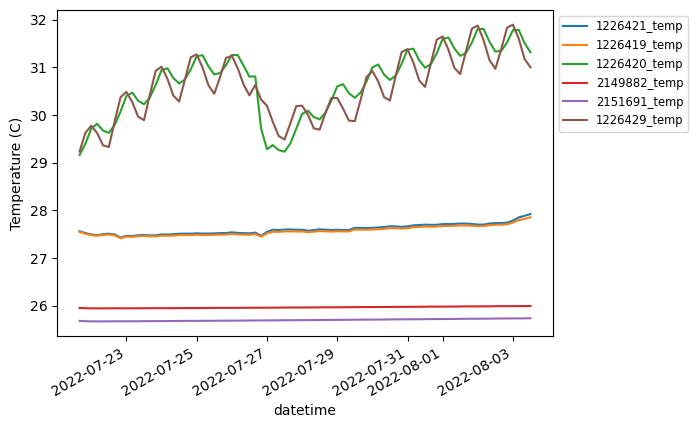

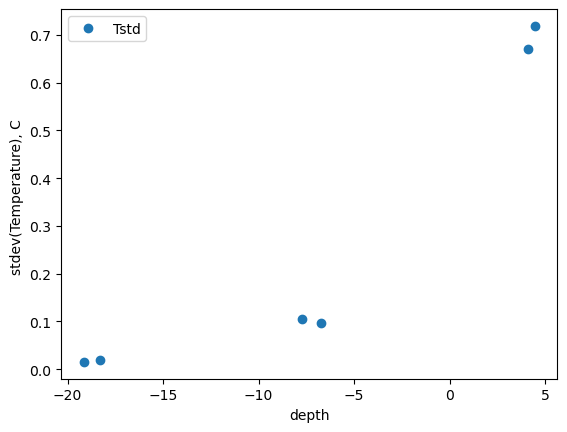

In [7]:
# subset to all rows that have a 'Therm(6)' column
df100hz_thermal = all_dataframes['100hz'].copy().dropna(subset=['Therm(6)'])
#df20hz_thermal = all_dataframes['20hz'].copy().dropna(subset=['Therm(2)'])
count = 0 
lod = []
for col in df100hz_thermal:
    if isinstance(col,str) and (col[0:2]=='12' or col[0:2]=='21'):
        count += 1
        oldcol = f'Therm({count})'
        newcol = f'{col}_temp'
        print(oldcol,'->',newcol)
        df100hz_thermal.rename(columns={oldcol:newcol}, inplace=True)
        this_transducer = LLE.get_transducer_metadata(col, transducersDF)
        depth = this_transducer['set_depth_ft']
        lod.append({'depth':depth, 'Tstd':df100hz_thermal[newcol].std()})
thermal_columns = [item for item in df100hz_thermal.columns if item.endswith('_temp')]
df100hz_thermal.plot(x='datetime', y=thermal_columns, kind='line', ylabel='Temperature (C)').legend(bbox_to_anchor=(1.0,1.0), fontsize='small')
dftemp = pd.DataFrame(lod)
dftemp.plot(x='depth', y='Tstd', style='o', ylabel='stdev(Temperature), C ')

## 4. Plot raw barometric data


<Axes: xlabel='datetime'>

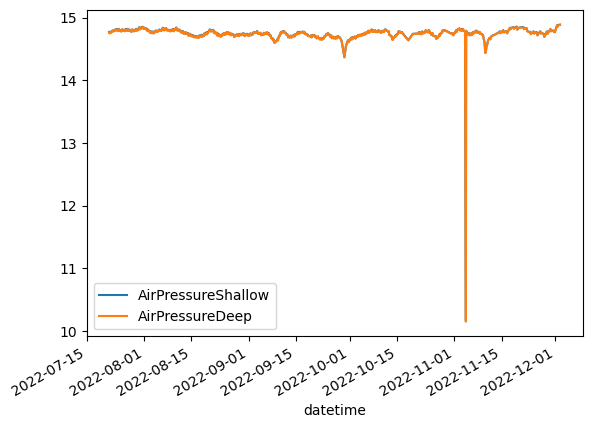

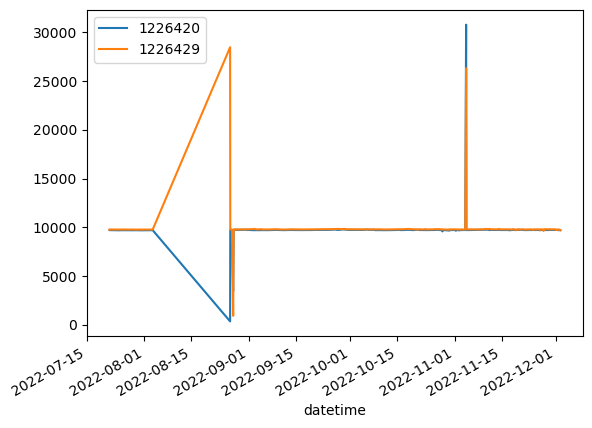

In [8]:
all_dataframes['baro'].plot(x='datetime', y=['AirPressureShallow', 'AirPressureDeep'], kind='line')
all_dataframes['100hz'].plot(x='datetime', y=['1226420', '1226429'], kind='line')

## 5. Correct all barometers and vibrating wire sensor data
- barometers are corrected for height only
- vibrating wire sensors in air are corrected for height also
- all vibrating wire sensors are corrected for sensitivity, and temperature
- vibrating wire sensors in water are corrected for barometric pressure too, from vibrating wire sensor in air

,TIMESTAMP,RECORD,uploaddate,subdir,basename,AirPressureShallow,AirPressureDeep,datetime
3,2022-07-21 13:54:21.790,0,20220826,Baro,100hz_Baro_Sensors_20220721135421_000.csv,14.773304,14.766960,2022-07-21 13:54:21.790
4,2022-07-21 16:00:00.010,753819,20220826,Baro,100hz_Baro_Sensors_20220721160000_001.csv,14.754274,14.752241,2022-07-21 16:00:00.010
10,2022-07-21 20:00:00.010,2193819,20220826,Baro,100hz_Baro_Sensors_20220721200000_002.csv,14.754250,14.748769,2022-07-21 20:00:00.010
15,2022-07-22 00:00:00.010,3633815,20220826,Baro,100hz_Baro_Sensors_20220722000000_003.csv,14.759185,14.758797,2022-07-22 00:00:00.010
19,2022-07-22 04:00:00.010,5073815,20220826,Baro,100hz_Baro_Sensors_20220722040000_004.csv,14.765824,14.759901,2022-07-22 04:00:00.010
...,...,...,...,...,...,...,...,...
2258,2022-12-01 12:00:00.010,143747119,20221202,Baro,100hz_Baro_Sensors_20221201120000_119.csv,14.877370,14.876700,2022-12-01 12:00:00.010
2262,2022-12-01 16:00:00.010,145187119,20221202,Baro,100hz_Baro_Sensors_20221201160000_120.csv,14.859900,14.857960,2022-12-01 16:00:00.010
2265,2022-12-01 20:00:00.010,146627119,20221202,Baro,100hz_Baro_Sensors_20221201200000_121.csv,14.880270,14.873140,2022-12-01 20:00:00.010
2268,2022-12-02 00:00:00.010,148067119,20221202,Baro,100hz_Baro_Sensors_20221202000000_122.csv,14.886800,14.880480,2022-12-02 00:00:00.010


<Axes: xlabel='datetime'>

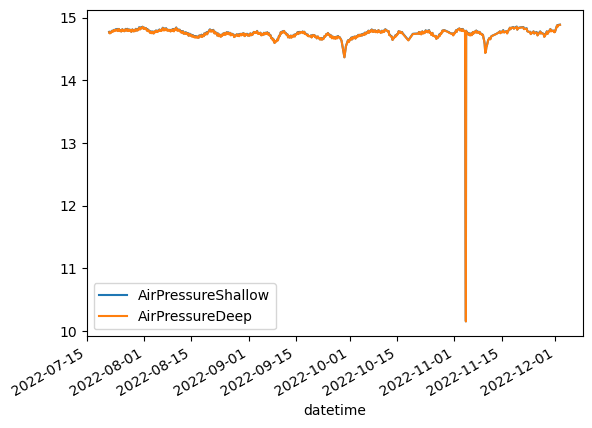

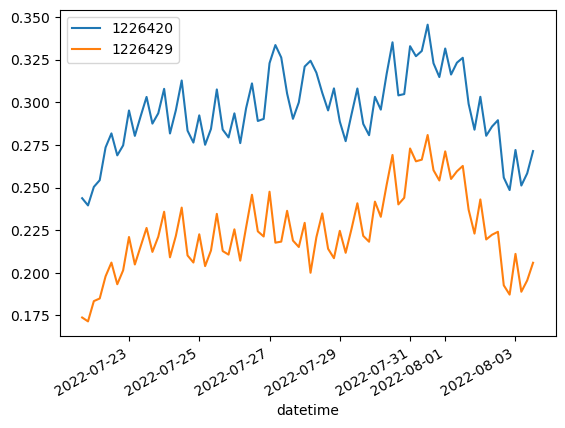

In [13]:
display(all_dataframes['baro'])
aircolumns = ['AirPressureShallow', 'AirPressureDeep', '1226420', '1226429']
dfbaro_elevationRemoved_PSI = LLE.correctBarometricData(all_dataframes['baro'], aircolumns[:2], transducersDF, temperatureCorrect=False, heightCorrect=True)  
dfbaro_elevationRemoved_PSI.plot(x='datetime', y=['AirPressureShallow', 'AirPressureDeep'], kind='line')
df100hz_elevationRemoved_aircolumnonly = LLE.correctBarometricData(df100hz_thermal, aircolumns[2:], transducersDF, temperatureCorrect=True, heightCorrect=True)
df100hz_elevationRemoved_PSI = LLE.rawdf2psidf(df100hz_elevationRemoved_aircolumnonly, transducersDF, temperatureCorrect=True, airpressureColumn='1226429', depthCorrect=False)
df100hz_elevationRemoved_PSI.plot(x='datetime', y=aircolumns[2:], kind='line')

## 6. Merge the dataframes after rounding timestamps to nearest minute
All time series from the all2.csv are 4-hourly since we have only 1 file per 4 hours. So we can round to the nearest minute to align times that are generally within 1-s

Drop columns we do not need

,1226421,1226419,1226420,2149882,2151691,1226429,1226421_temp,1226419_temp,1226420_temp,2149882_temp,2151691_temp,1226429_temp,nearestminute,AirPressureShallow,AirPressureDeep
0,18.207421,17.515755,0.243783,23.060579,22.753112,0.173795,27.561035,27.545471,30.319580,25.950348,25.679871,30.127380,2022-07-21 16:00:00,14.756270,14.754263
1,18.209748,17.518469,0.239559,23.062856,22.755313,0.171514,27.521179,27.505676,30.319580,25.944275,25.670624,30.127380,2022-07-21 20:00:00,14.756245,14.750791
2,18.197880,17.506854,0.250424,23.050954,22.743389,0.183415,27.492371,27.479401,30.319580,25.941925,25.667999,30.127380,2022-07-22 00:00:00,14.761181,14.760819
3,18.196373,17.505490,0.254347,23.049428,22.741861,0.184940,27.476013,27.464600,30.319580,25.941284,25.667755,30.127380,2022-07-22 04:00:00,14.767820,14.761923
4,18.183340,17.492293,0.273572,23.036421,22.728855,0.197947,27.499451,27.482025,30.319580,25.940979,25.667847,30.127380,2022-07-22 08:00:00,14.787139,14.783863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,18.187056,17.494139,0.248564,23.039094,22.731968,0.187231,27.740326,27.705566,31.319580,25.987427,25.729462,31.127380,2022-08-02 20:00:00,14.760688,14.755793
74,18.163125,17.469866,0.272073,23.015212,22.708089,0.211113,27.783051,27.741486,31.319580,25.988190,25.729797,31.127380,2022-08-03 00:00:00,14.783177,14.777153
75,18.185256,17.491494,0.251231,23.037421,22.730305,0.188904,27.851074,27.794891,31.319580,25.988678,25.730652,31.127380,2022-08-03 04:00:00,14.761443,14.753369
76,18.178573,17.484575,0.258380,23.030776,22.723670,0.195550,27.883545,27.820007,31.319580,25.989471,25.731873,31.127380,2022-08-03 08:00:00,14.769860,14.763113


<Axes: xlabel='nearestminute'>

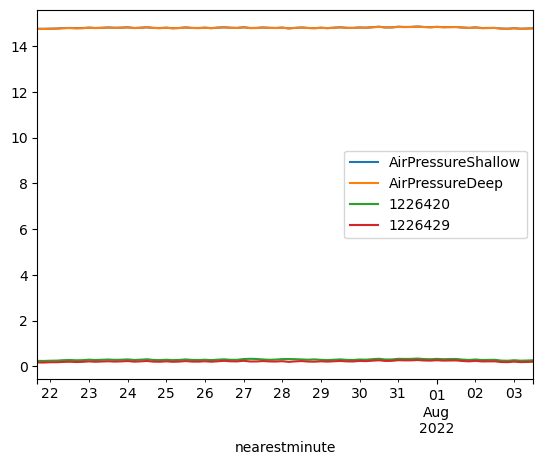

In [14]:
LLE.round_datetime(df100hz_elevationRemoved_PSI, freq='min' )
LLE.round_datetime(dfbaro_elevationRemoved_PSI, freq='min')
dfmerged1 = LLE.merge_and_drop(df100hz_elevationRemoved_PSI, dfbaro_elevationRemoved_PSI, on='nearestminute')
display(dfmerged1)
dfmerged1.plot(x='nearestminute', y=aircolumns, kind='line')

## 7. Correlate the air pressure columns - and compare their means too


,AirPressureShallow,AirPressureDeep,1226420,1226429
AirPressureShallow,1.000000,0.993076,0.864787,0.975199
AirPressureDeep,0.993076,1.000000,0.872658,0.974976
1226420,0.864787,0.872658,1.000000,0.871275
1226429,0.975199,0.974976,0.871275,1.000000


,AirPressureShallow,AirPressureDeep,1226420,1226429
AirPressureShallow,0.000000,0.003058,14.505683,14.577802
AirPressureDeep,-0.003058,0.000000,14.502625,14.574744
1226420,-14.505683,-14.502625,0.000000,0.072119
1226429,-14.577802,-14.574744,-0.072119,0.000000


Shifting AirPressureShallow by -0.0 PSI
Shifting AirPressureDeep by 0.0030579897466864736 PSI
Shifting 1226420 by 14.50568334838111 PSI
Shifting 1226429 by 14.577802141446423 PSI


<Axes: xlabel='nearestminute', ylabel='PSI'>

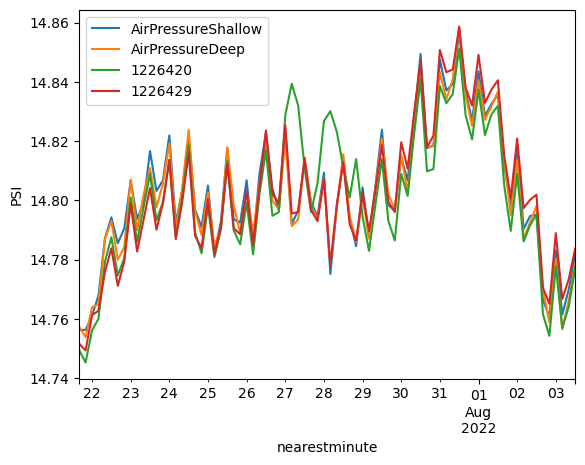

In [15]:
xcorrdf1, dcshiftdf1 = LLE.xcorr_columns(dfmerged1, aircolumns)
dfshifted1, dcshifts1 = LLE.apply_dcshifts(dfmerged1, xcorrdf1, dcshiftdf1)
dfshifted1.plot(x='nearestminute', y=aircolumns, kind='line', ylabel='PSI')

## 8. Repeat the analysis, but don't make a temperature correction
Improves correlation between 1226420 and analog barometers by 2%, but degrades 1226429 against same by almost 1%
Improves correlation between 1226420 and 1226429 by 4% 
However, if we stick to using 1226429, this loss in performance is fine.
Best shifts are now:
* +14.423795 PSI to align 1226420 with AirPressureShallow
* +14.556290 PSI to align 1226429 with AirPressureShallow

,1226421,1226419,1226420,2149882,2151691,1226429,1226421_temp,1226419_temp,1226420_temp,2149882_temp,2151691_temp,1226429_temp,nearestminute,AirPressureShallow,AirPressureDeep
0,9178.673828,9502.565918,0.312926,8638.986328,8369.739746,0.191992,27.561035,27.545471,30.319580,25.950348,25.679871,30.127380,2022-07-21 16:00:00,14.756270,14.754263
1,9178.673828,9502.565918,0.310775,8638.986328,8369.739746,0.190649,27.521179,27.505676,30.319580,25.944275,25.670624,30.127380,2022-07-21 20:00:00,14.756245,14.750791
2,9178.673828,9502.565918,0.324429,8638.986328,8369.739746,0.202903,27.492371,27.479401,30.319580,25.941925,25.667999,30.127380,2022-07-22 00:00:00,14.761181,14.760819
3,9178.673828,9502.565918,0.329229,8638.986328,8369.739746,0.204064,27.476013,27.464600,30.319580,25.941284,25.667755,30.127380,2022-07-22 04:00:00,14.767820,14.761923
4,9178.673828,9502.565918,0.347202,8638.986328,8369.739746,0.216455,27.499451,27.482025,30.319580,25.940979,25.667847,30.127380,2022-07-22 08:00:00,14.787139,14.783863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,9179.673828,9503.565918,0.338455,8639.986328,8370.739746,0.211622,27.740326,27.705566,31.319580,25.987427,25.729462,31.127380,2022-08-02 20:00:00,14.760688,14.755793
74,9179.673828,9503.565918,0.364249,8639.986328,8370.739746,0.235658,27.783051,27.741486,31.319580,25.988190,25.729797,31.127380,2022-08-03 00:00:00,14.783177,14.777153
75,9179.673828,9503.565918,0.343450,8639.986328,8370.739746,0.212745,27.851074,27.794891,31.319580,25.988678,25.730652,31.127380,2022-08-03 04:00:00,14.761443,14.753369
76,9179.673828,9503.565918,0.348155,8639.986328,8370.739746,0.218376,27.883545,27.820007,31.319580,25.989471,25.731873,31.127380,2022-08-03 08:00:00,14.769860,14.763113


,AirPressureShallow,AirPressureDeep,1226420,1226429
AirPressureShallow,1.000000,0.993076,0.888314,0.967004
AirPressureDeep,0.993076,1.000000,0.892914,0.965649
1226420,0.888314,0.892914,1.000000,0.915960
1226429,0.967004,0.965649,0.915960,1.000000


,AirPressureShallow,AirPressureDeep,1226420,1226429
AirPressureShallow,0.000000,0.003058,14.423795,14.556290
AirPressureDeep,-0.003058,0.000000,14.420737,14.553232
1226420,-14.423795,-14.420737,0.000000,0.132495
1226429,-14.556290,-14.553232,-0.132495,0.000000


Shifting AirPressureShallow by -0.0 PSI
Shifting AirPressureDeep by 0.0030579897466864736 PSI
Shifting 1226420 by 14.423794873603889 PSI
Shifting 1226429 by 14.556289842715955 PSI


,AirPressureShallow,AirPressureDeep,1226420,1226429
AirPressureShallow,0.000000,0.000000,0.023527,-0.008195
AirPressureDeep,0.000000,0.000000,0.020257,-0.009327
1226420,0.023527,0.020257,0.000000,0.044685
1226429,-0.008195,-0.009327,0.044685,0.000000


,AirPressureShallow,AirPressureDeep,1226420,1226429
AirPressureShallow,0.000000,0.000000,-0.081888,-0.021512
AirPressureDeep,0.000000,0.000000,-0.081888,-0.021512
1226420,0.081888,0.081888,0.000000,0.060376
1226429,0.021512,0.021512,-0.060376,0.000000


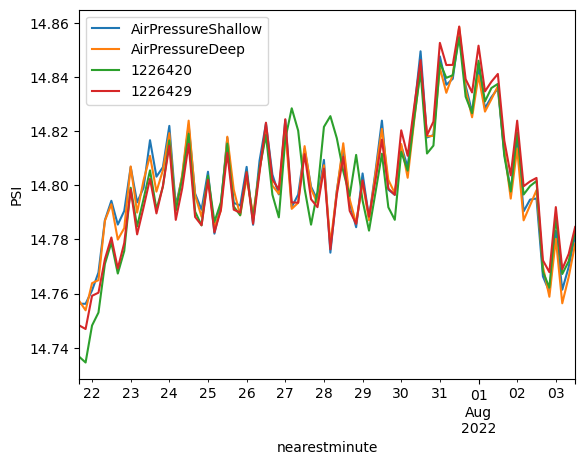

In [17]:
df100hz_elevationRemoved_aircolumnonly_noT = LLE.correctBarometricData(df100hz_thermal, ['1226420', '1226429'], transducersDF, temperatureCorrect=False, heightCorrect=True)

LLE.round_datetime(df100hz_elevationRemoved_aircolumnonly_noT, freq='min' )
dfmerged2 = LLE.merge_and_drop(df100hz_elevationRemoved_aircolumnonly_noT, dfbaro_elevationRemoved_PSI, on='nearestminute')
display(dfmerged2)

xcorrdf2, dcshiftdf2 = LLE.xcorr_columns(dfmerged2, aircolumns)
dfshifted2, dcshifts2 = LLE.apply_dcshifts(dfmerged2, xcorrdf2, dcshiftdf2)
dfshifted2.plot(x='nearestminute', y=aircolumns, kind='line', ylabel='PSI')

dfxcorrdiff = xcorrdf2-xcorrdf1
dfxcorrdiff_styled = dfxcorrdiff.style.set_caption('Difference in cross-correlation')
dfshiftdiff = dcshiftdf2-dcshiftdf1
dfshiftdiff_styled = dfshiftdiff.style.set_caption('Difference in DC levels')

display(dfxcorrdiff_styled)
display(dfshiftdiff_styled)

## 9. Full workflow for 100 Hz data


,TIMESTAMP_x,RECORD_x,uploaddate_x,subdir_x,basename_x,AirPressureShallow,AirPressureDeep,datetime_x,nearestminute,TIMESTAMP_y,...,Therm(4),Therm(5),Therm(6),DynStdDev(1),DynStdDev(2),DynStdDev(3),DynStdDev(4),DynStdDev(5),DynStdDev(6),datetime_y
0,2022-07-21 16:00:00.010,753819,20220826,Baro,100hz_Baro_Sensors_20220721160000_001.csv,14.756270,14.754263,2022-07-21 16:00:00.010,2022-07-21 16:00:00,2022-07-21 16:00:00.010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-21 16:00:00.010
1,2022-07-21 16:00:00.010,753819,20220826,Baro,100hz_Baro_Sensors_20220721160000_001.csv,14.756270,14.754263,2022-07-21 16:00:00.010,2022-07-21 16:00:00,2022-07-21 16:00:01.000,...,25.950348,25.679871,29.232971,0.213020,0.207875,0.274275,0.250625,0.196379,0.277220,2022-07-21 16:00:01.000
2,2022-07-21 20:00:00.010,2193819,20220826,Baro,100hz_Baro_Sensors_20220721200000_002.csv,14.756245,14.750791,2022-07-21 20:00:00.010,2022-07-21 20:00:00,2022-07-21 20:00:00.010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-21 20:00:00.010
3,2022-07-21 20:00:00.010,2193819,20220826,Baro,100hz_Baro_Sensors_20220721200000_002.csv,14.756245,14.750791,2022-07-21 20:00:00.010,2022-07-21 20:00:00,2022-07-21 20:00:01.000,...,25.944275,25.670624,29.626465,0.231678,0.188281,0.233037,0.248869,0.196529,0.283193,2022-07-21 20:00:01.000
4,2022-07-22 00:00:00.010,3633815,20220826,Baro,100hz_Baro_Sensors_20220722000000_003.csv,14.761181,14.760819,2022-07-22 00:00:00.010,2022-07-22 00:00:00,2022-07-22 00:00:00.010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-22 00:00:00.010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,2022-12-01 12:00:00.010,143747119,20221202,Baro,100hz_Baro_Sensors_20221201120000_119.csv,14.879366,14.878722,2022-12-01 12:00:00.010,2022-12-01 12:00:00,2022-12-01 12:00:00.010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-12-01 12:00:00.010
638,2022-12-01 16:00:00.010,145187119,20221202,Baro,100hz_Baro_Sensors_20221201160000_120.csv,14.861896,14.859982,2022-12-01 16:00:00.010,2022-12-01 16:00:00,2022-12-01 16:00:00.010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-12-01 16:00:00.010
639,2022-12-01 20:00:00.010,146627119,20221202,Baro,100hz_Baro_Sensors_20221201200000_121.csv,14.882266,14.875162,2022-12-01 20:00:00.010,2022-12-01 20:00:00,2022-12-01 20:00:00.010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-12-01 20:00:00.010
640,2022-12-02 00:00:00.010,148067119,20221202,Baro,100hz_Baro_Sensors_20221202000000_122.csv,14.888796,14.882502,2022-12-02 00:00:00.010,2022-12-02 00:00:00,2022-12-02 00:00:00.010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-12-02 00:00:00.010


,1226419,1226421,2151691,2149882
0,3.063846,3.688616,8.201193,8.540194
1,3.064794,3.689564,8.202141,8.541142
2,3.067198,3.691969,8.204545,8.543546
3,3.066138,3.690908,8.203484,8.542485
4,3.053294,3.678064,8.190641,8.529642
...,...,...,...,...
637,3.048835,3.673605,8.186181,8.525183
638,3.061511,3.686281,8.198857,8.537859
639,3.043448,3.668218,8.180795,8.519796
640,3.044567,3.669337,8.181913,8.520914


the estimated set_depth for sensor 1226419 is -2.19 m or -7.18 ft
the estimated set_depth for sensor 1226421 is -2.63 m or -8.62 ft
the estimated set_depth for sensor 2151691 is -5.80 m or -19.03 ft
the estimated set_depth for sensor 2149882 is -6.04 m or -19.81 ft


<Axes: xlabel='nearestminute', ylabel='Meters'>

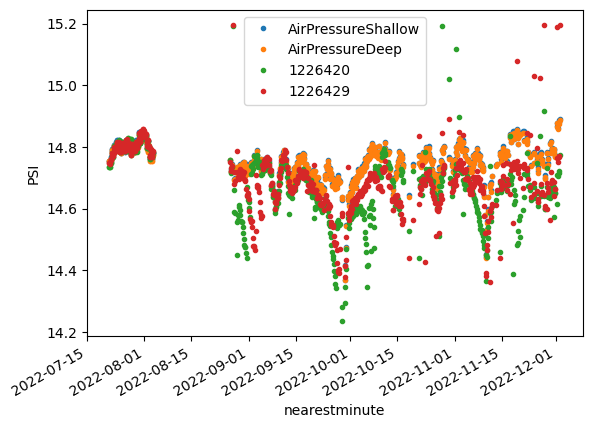

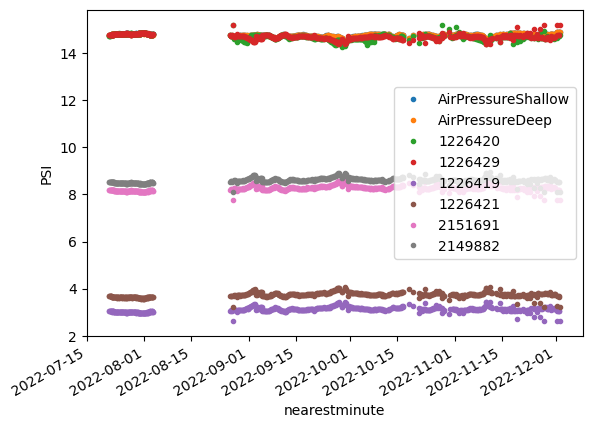

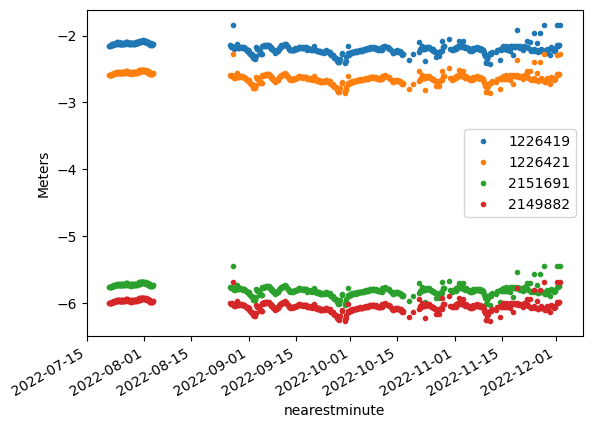

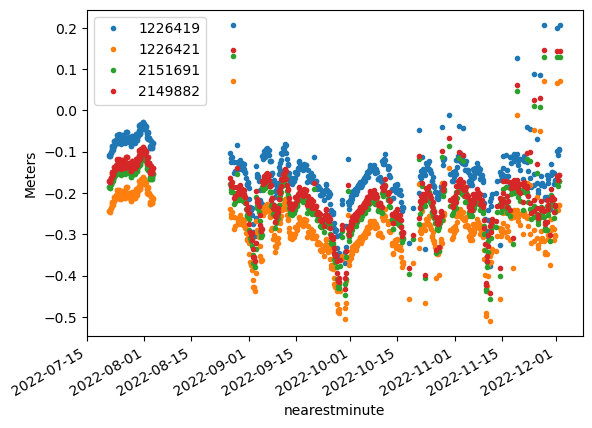

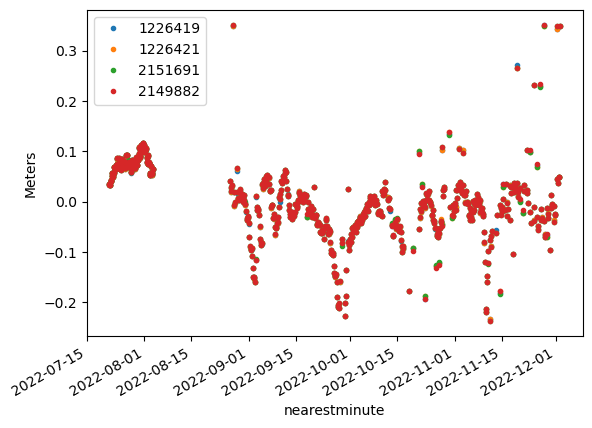

In [18]:
# 10.1: Get raw 100 Hz data and remove anything with spikes

# 10.2: Correct analog and digital air column transducers for calibration, elevation above water, and apply DC shift (no temperature correction)
dfbaro_dcshifted = LLE.correctBarometricData(all_dataframes['baro'], aircolumns[:2], transducersDF, temperatureCorrect=False, heightCorrect=True, dcshifts=dcshifts2)
df100hz_dcshifted = LLE.correctBarometricData(all_dataframes['100hz'], aircolumns[2:], transducersDF, temperatureCorrect=False, heightCorrect=True, dcshifts=dcshifts2)

# 10.3: Merge and plot
LLE.round_datetime(df100hz_dcshifted, freq='min')
LLE.round_datetime(dfbaro_dcshifted, freq='min')
dfmerged_dcshifted = LLE.merge_and_drop(dfbaro_dcshifted, df100hz_dcshifted, on='nearestminute', drop=False)
display(dfmerged_dcshifted)
dfmerged_dcshifted.plot(x='nearestminute', y=aircolumns, style='.', ylabel='PSI')

# 10.4: Correct digital water column transducers for calibration and barometric pressure
correctedAllSensorsPSI = LLE.rawdf2psidf(dfmerged_dcshifted, transducersDF, temperatureCorrect=False, airpressureColumn='1226429', depthCorrect=False)
watercolumns = ['1226419', '1226421', '2151691', '2149882']
display(correctedAllSensorsPSI[watercolumns])

# 10.5: plot PSI
correctedAllSensorsPSI.plot(x='nearestminute', y=aircolumns+watercolumns, style='.', ylabel='PSI')

# 10.6: convert to water levels in meters
correctedAllSensorsMeters = LLE.psi2meters(correctedAllSensorsPSI, watercolumns)
correctedAllSensorsMeters.plot(x='nearestminute', y=watercolumns, style='.', ylabel='Meters')

# 10.7: convert to water levels in meters relative to the set depth measured by Steve Krupa
relativeAllSensorsMeters = LLE.relative_to_set_depth(correctedAllSensorsMeters, transducersDF, watercolumns)
relativeAllSensorsMeters.plot(x='nearestminute', y=watercolumns, style='.', ylabel='Meters')

# 10.8: estimate correct set depths from median of each, and shift by this amount
estimatedAllSensorsMeters = LLE.estimate_sensor_depths(correctedAllSensorsMeters, watercolumns)
estimatedAllSensorsMeters.plot(x='nearestminute', y=watercolumns, style='.', ylabel='Meters')   